In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    percentile: int = 20,
    min_com_size: int = 3,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[percentile])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            msg1 = 'pearson\n(th = {:.2f})\n'
            msg1 = msg1.format(np.min(pearson[percentile][pearson[percentile] > 0]))
            msg2 = 'spearman\n(th = {:.2f})\n'
            msg2 = msg2.format(np.min(spearman[percentile][spearman[percentile] > 0]))
            axes[0, ii].set_ylabel(msg1, fontsize=12)
            axes[1, ii].set_ylabel(msg2, fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    figsize=None,
    colorbar=False,):
    
    percentiles = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(percentiles)) if figsize is None else figsize
    fig, axes = plt.subplots(len(percentiles), 2, figsize=figsize)

    for ii, perc in enumerate(sorted(percentiles, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 0].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=12, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[perc])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 1].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=12, y=1.03)
        axes[ii, 1].set_ylabel('Using {:d} {:s} \n'.format(perc, '%'), fontsize=12)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(
    organized_data: dict,
    include: Union[range, List[int]] = None,
    config: Config = None,):
    
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = list(regions.keys())[:19] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy()
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy().astype(float)
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas': atlas,
        'atlas_limited': x,
        'contour': contour,
    }
    return output

## SVINET

In [3]:
svinet_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/svinet')
cmaps = {
    0: 'Blues',
    1: 'Reds',
    2: 'Greens',
    3: 'Greys',
    4: 'Purples',
    5: 'Oranges',
}

In [4]:
config = Config()

subject = 6
session = 1
num_kmeans_regions = 256

lowcut = 0.002
highcut = 0.9
order = 2

df = pd.DataFrame()
df_bp = pd.DataFrame()
for run in [1, 3, 5, 7]:
    load = load_organized_data(
        folder='atlas-{:d}_unfiltered_unnormalized'.format(num_kmeans_regions),
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    ca = {k: v for k, v in load['ca'].items()}
    ca_bp = {
        k: apply_bandpass(
            x=v,
            fs=config.ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order, )
        for k, v in load['ca'].items()
    }
    
    # normalize
    mean = np.mean([item.mean() for item in ca.values()])
    sd = np.mean([item.std() for item in ca.values()])
    ca_n = {k: (v - mean) / sd for k, v in ca.items()}
    
    mean = np.mean([item.mean() for item in ca_bp.values()])
    sd = np.mean([item.std() for item in ca_bp.values()])
    ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}

    df = pd.concat([df, pd.DataFrame.from_dict(ca_n)])
    df_bp = pd.concat([df_bp, pd.DataFrame.from_dict(ca_bp_n)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

atls_org = organize_atlas(load)

In [5]:
percentiles = [25, 20, 18, 15, 13, 10]
corrs = get_corrs(df, percentiles=percentiles)
corrs_bp = get_corrs(df_bp, percentiles=percentiles)

graphs = {perc: nx.from_numpy_matrix(a) for perc, a in corrs['pearson'].items()}
graphs_bp = {perc: nx.from_numpy_matrix(a) for perc, a in corrs_bp['pearson'].items()}

### Save network

In [6]:
perc = 25
post = 'perc-{:d}'.format(perc)

networks = {
    'ca_{:s}'.format(post): graphs[perc],
    'ca_bp_{:s}'.format(post): graphs_bp[perc],
}
networks.update({
    'ca_cfg_{:s}'.format(post): mk_config_model(networks['ca_{:s}'.format(post)], weighted=True),
    'ca_cfg_bp_{:s}'.format(post): mk_config_model(networks['ca_bp_{:s}'.format(post)], weighted=True),
})

In [7]:
for name, g in networks.items():
    save_dir = pjoin(svinet_ws, name)
    os.makedirs(save_dir, exist_ok=True)
    save_edgelist(g, name=name, save_dir=save_dir)

### Run alg

- do this in terminal

### Load results

In [9]:
num_comm = 4

def get_filter_fn(num_comm=4):
    keywords = ['k{:d}'.format(num_comm)]
    def filter_fn(x):
        return all(k in x for k in keywords)
    return filter_fn

In [10]:
svinet_results = defaultdict(list)
for name in tqdm(networks):
    save_dir = pjoin(svinet_ws, name)
    results_list = sorted(next(os.walk(save_dir))[1])
    results_list = list(filter(get_filter_fn(num_comm), results_list))
    for item in tqdm(results_list, leave=False):
        results_dir = pjoin(save_dir, item)
        try:
            result = load_svinet(results_dir)
        except FileNotFoundError:
            continue
        svinet_results[name].append(result)
svinet_results = dict(svinet_results)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [11]:
{k: len(v) for k, v in svinet_results.items()}

{'ca_perc-25': 1000, 'ca_bp_perc-25': 1000}

### Figure out combining data

In [12]:
from time import time
from copy import deepcopy as dc
from sklearn.cluster import KMeans

import sklearnex
sklearnex.patch_sklearn()

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [13]:
canonical_comms = {}
kmeans = {}
svinet_ordered = defaultdict(list)

pbar = tqdm(svinet_results)
for key in pbar:
    prototypes = []
    for run in svinet_results[key]:
        for comm_list in run['community'].values():
            proto = np.zeros(load['atlas_kmeans'].shape)
            for node in comm_list:
                region_id = node_labels[node]
                proto[load['atlas_kmeans'] == region_id] = 1
            prototypes.append(proto.reshape(1, -1))
    prototypes = np.concatenate(prototypes)
    
    start = time()
    model = KMeans(
        n_clusters=num_comm,
        random_state=42,
    ).fit(prototypes)
    end = time()
    
    delta = convert_time(end-start, verbose=False)
    pbar.set_description(delta)
    
    kmeans[key] = model
    canonical_comms[key] = model.cluster_centers_
    
    for run in tqdm(svinet_results[key], leave=False):
        _comms = []
        for comm_idx, comm_list in run['community'].items():
            proto = np.zeros(load['atlas_kmeans'].shape)
            for node in comm_list:
                region_id = node_labels[node]
                proto[load['atlas_kmeans'] == region_id] = 1
            _comms.append(proto.reshape(1, -1))

        canonical_idxs = model.predict(np.concatenate(_comms))
        if len(np.unique(canonical_idxs)) != num_comm:
            continue

        comm_ordered = {canonical_idxs[i]: comm_list for i, comm_list in run['community'].items()}
        result_ordered = {
            'community': dict(sorted(comm_ordered.items())),
            'membership': {n: mem_vec[canonical_idxs] for n, mem_vec in run['membership'].items()},
            'partition': {n: canonical_idxs[i] for n, i in run['partition'].items()},
        }
        svinet_ordered[key].append(result_ordered)

svinet_ordered = dict(svinet_ordered)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
{k: len(v) for k, v in svinet_ordered.items()}

{'ca_perc-25': 910, 'ca_bp_perc-25': 836}

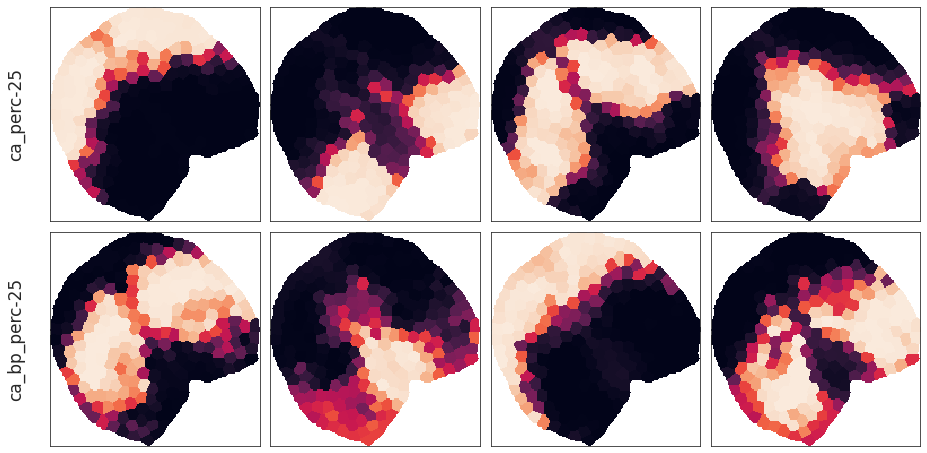

In [16]:
sns.set_style('white')
nrows, ncols = len(canonical_comms), num_comm
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 3.2 * nrows))

for i, key in enumerate(canonical_comms):
    for j in range(num_comm):
        c = canonical_comms[key][j].reshape(load['atlas'].shape)
        axes[i, j].imshow(np.ma.masked_where(~load['mask'], c), interpolation='none')
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if j == 0:
            axes[i, j].set_ylabel(key + '\n', fontsize=17)

fig.tight_layout()
fig.savefig('svinet_cannonical_perc-{:d}.pdf'.format(perc), dpi=300, bbox_inches='tight')
plt.show()

In [17]:
th = 0.3

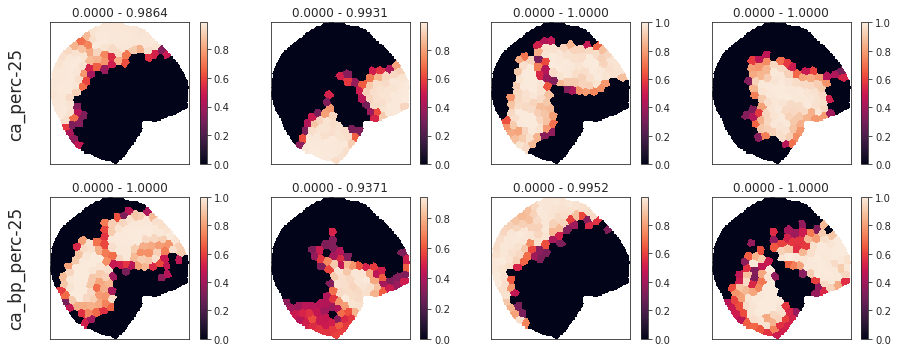

In [18]:
sns.set_style('white')
nrows, ncols = len(canonical_comms), num_comm
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 2.5 * nrows))

for i, key in enumerate(canonical_comms):
    for j in range(num_comm):
        c = dc(canonical_comms[key][j].reshape(load['atlas'].shape))
        c[c < th] = 0.
        c = np.ma.masked_where(~load['mask'], c)
        im = axes[i, j].imshow(c, interpolation='none')
        plt.colorbar(im, ax=axes[i, j])
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        axes[i, j].set_title('{:.4f} - {:.4f}'.format(c.min(), c.max()))
        
        if j == 0:
            axes[i, j].set_ylabel(key + '\n', fontsize=17)

fig.tight_layout()
# fig.savefig('svinet_cannonical_perc-{:d}.pdf'.format(perc), dpi=300, bbox_inches='tight')
plt.show()

In [24]:
name = 'ca_perc-25'
j = 0
c = dc(canonical_comms[key][j].reshape(load['atlas'].shape))
c[c < th] = 0.
c[~load['mask']] = -1

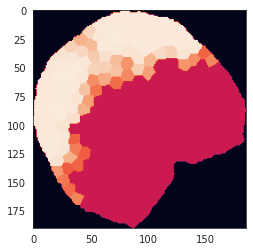

In [25]:
plt.imshow(c)

<AxesSubplot:ylabel='Count'>

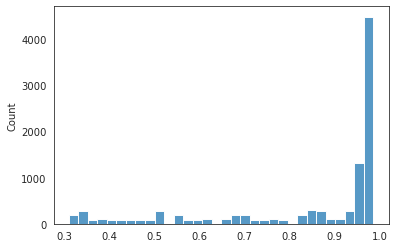

In [26]:
x = c.copy()
sns.histplot(x[x>0])

In [27]:
bins = np.linspace(0, 1, 11)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [28]:
name = 'ca_perc-25'

th_all = []
for run_idx, run in enumerate(svinet_ordered[name]):
    nodes, mem_vecs = zip(*run['membership'].items())
    pi = np.concatenate([v.reshape(-1, 1) for v in mem_vecs], axis=1)
    th = collections.Counter(pi.flatten()).most_common()[0][0] * 1.5
    th_all.append(th)
collections.Counter(th_all)

Counter({0.003: 910})

In [29]:
th = 0.003

In [30]:
name = 'ca_perc-25'

dict_list = []
dict_list_cut = []
for run_idx, run in tqdm(enumerate(svinet_ordered[name])):
    nodes, mem_vecs = zip(*run['membership'].items())
    pi = np.concatenate([v.reshape(-1, 1) for v in mem_vecs], axis=1)
    pi[pi < th] = 0
    for comm_idx in range(num_comm):
        mem_vec = pi[comm_idx]
        
        # save data
        data_dict = {
            'name': [name] * len(nodes),
            'OC_idx': [comm_idx] * len(nodes),
            'run_idx': [run_idx] * len(nodes),
            'node': nodes,
            'pi': mem_vec,
        }
        dict_list.append(data_dict)
        
        # quantize
        pi_cut = pd.cut(mem_vec[mem_vec > 0], bins).value_counts()
        intervals = pi_cut.index.tolist()
        counts = pi_cut.values.tolist()
        percent = [x/sum(counts) * 100 for x in counts]
        
        data_dict = {
            'name': [name] * len(pi_cut),
            'OC_idx': [comm_idx] * len(pi_cut),
            'run_idx': [run_idx] * len(pi_cut),
            'interval': intervals,
            'count': counts,
            'percent': percent, 
        }
        dict_list_cut.append(data_dict)

df_memship = pd.DataFrame.from_dict(merge_dicts(dict_list))
df_memship_cut = pd.DataFrame.from_dict(merge_dicts(dict_list_cut))

0it [00:00, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [31]:
df_memship

,name,OC_idx,run_idx,node,pi
0,ca_perc-25,0,0,0,0.0
1,ca_perc-25,0,0,1,0.0
2,ca_perc-25,0,0,2,0.0
3,ca_perc-25,0,0,3,0.0
4,ca_perc-25,0,0,4,0.0
...,...,...,...,...,...
931835,ca_perc-25,3,909,251,0.0
931836,ca_perc-25,3,909,252,0.0
931837,ca_perc-25,3,909,253,0.0
931838,ca_perc-25,3,909,254,0.0


In [32]:
df_memship_cut

,name,OC_idx,run_idx,interval,count,percent
0,ca_perc-25,0,0,"(0.0, 0.1]",8,6.060606
1,ca_perc-25,0,0,"(0.1, 0.2]",1,0.757576
2,ca_perc-25,0,0,"(0.2, 0.3]",3,2.272727
3,ca_perc-25,0,0,"(0.3, 0.4]",11,8.333333
4,ca_perc-25,0,0,"(0.4, 0.5]",11,8.333333
...,...,...,...,...,...,...
36395,ca_perc-25,3,909,"(0.5, 0.6]",7,6.930693
36396,ca_perc-25,3,909,"(0.6, 0.7]",2,1.980198
36397,ca_perc-25,3,909,"(0.7, 0.8]",0,0.000000
36398,ca_perc-25,3,909,"(0.8, 0.9]",1,0.990099


In [38]:
xticklabels = [np.round(x, decimals=1) for x in bins]
xticks = np.arange(-0.5, len(xticklabels) - 0.5)

cmap = 'turbo'
palette = sns.color_palette(cmap, n_colors=len(bins))
palette

[(0.2628, 0.30639, 0.72968),
 (0.27381, 0.52069, 0.97899),
 (0.15844, 0.73551, 0.92305),
 (0.10342, 0.896, 0.715),
 (0.33517, 0.98234, 0.46325),
 (0.64362, 0.98999, 0.23356),
 (0.8501, 0.89328, 0.21074),
 (0.98, 0.73, 0.22161),
 (0.9836, 0.49291, 0.12849),
 (0.89298, 0.26981, 0.03993),
 (0.72686, 0.11867, 0.00695)]

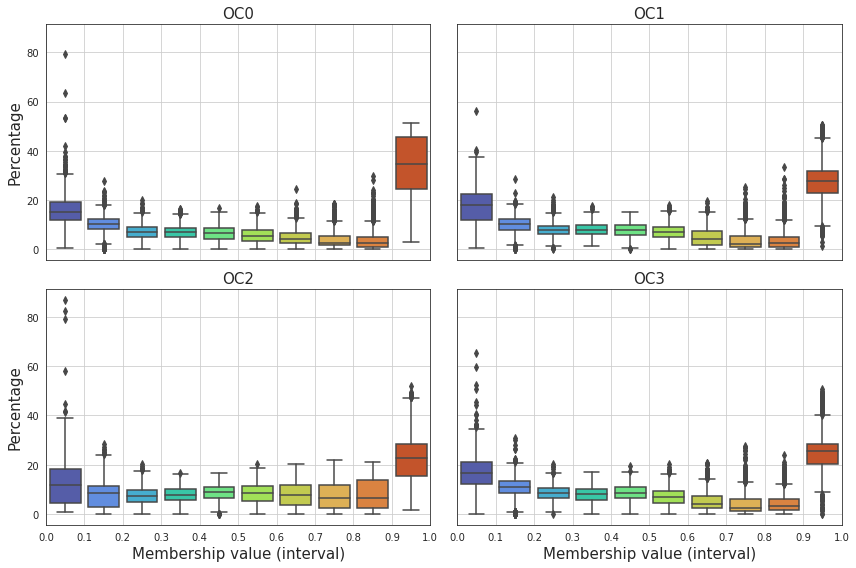

In [39]:
sns.set_style('white')
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8), sharex='all', sharey='all')

for comm_idx in range(num_comm):
    i, j = comm_idx//ncols, comm_idx%ncols
    selected_df = df_memship_cut.loc[df_memship_cut.OC_idx == comm_idx]
    
    # plot
    sns.boxplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        palette=palette,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title('OC{:d}'.format(comm_idx), fontsize=15)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=15)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=15)
    else:
        axes[i, j].set_ylabel('')

fig.tight_layout()
plt.show()

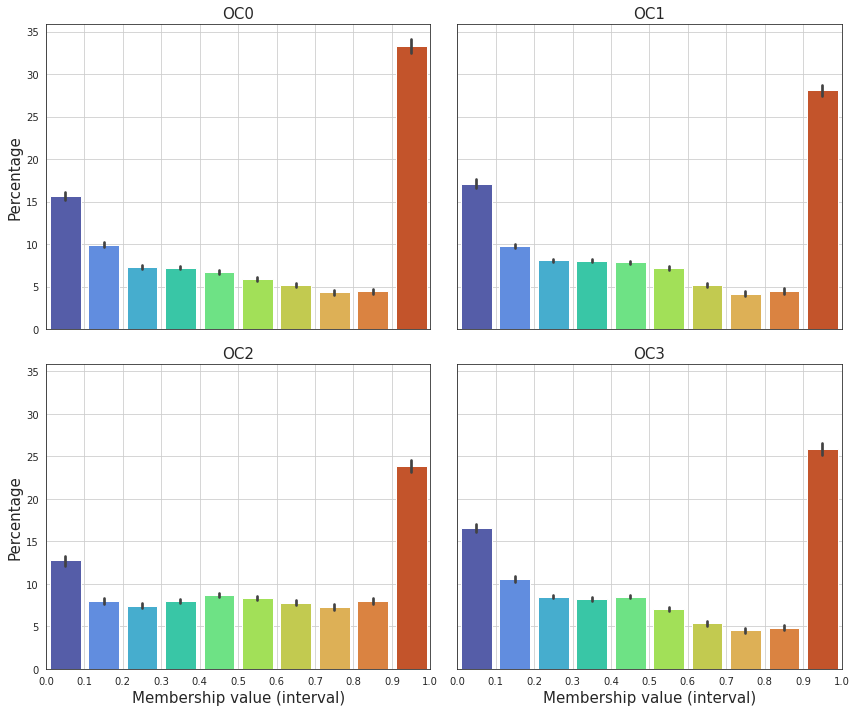

In [40]:
sns.set_style('white')
nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10), sharex='all', sharey='all')

for comm_idx in range(num_comm):
    i, j = comm_idx//ncols, comm_idx%ncols
    selected_df = df_memship_cut.loc[df_memship_cut.OC_idx == comm_idx]
    
    # plot
    sns.barplot(
        data=selected_df,
        x='interval',
        y='percent',
        saturation=0.7,
        estimator=np.mean,
        ci=95,
        palette=palette,
        ax=axes[i, j],
    )
    
    # ticks
    axes[i, j].set_xticks(xticks)
    axes[i, j].set_xticklabels(xticklabels)
    axes[i, j].grid()
    
    # labels
    axes[i, j].set_title('OC{:d}'.format(comm_idx), fontsize=15)
    if i == nrows - 1:
        axes[i, j].set_xlabel('Membership value (interval)', fontsize=15)
    else:
        axes[i, j].set_xlabel('')
    if j == 0:
        axes[i, j].set_ylabel('Percentage', fontsize=15)
    else:
        axes[i, j].set_ylabel('')

fig.tight_layout()
plt.show()

In [125]:
model = kmeans[name]

In [144]:
from sklearn.metrics.pairwise import cosine_similarity

In [163]:
score1 = []
score2 = []

for run_idx, run in enumerate(svinet_results[key]):
    
    _comms = []
    for comm_idx, comm_list in run['community'].items():
        proto = np.zeros(load['atlas_kmeans'].shape)
        for node in comm_list:
            region_id = node_labels[node]
            proto[load['atlas_kmeans'] == region_id] = 1
        _comms.append(proto.reshape(1, -1))
    
    _comms = np.concatenate(_comms)
    canonical_idxs = model.predict(_comms)
    score1.append(model.score(_comms))
    cos_sim = cosine_similarity(model.cluster_centers_, _comms[canonical_idxs])
    score2.append(np.diag(cos_sim).mean())

score1 = np.array(score1)
score2 = np.array(score2)

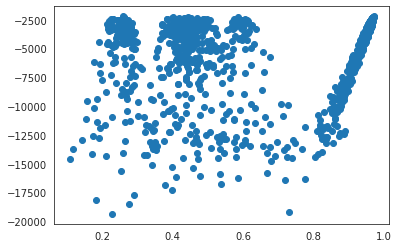

In [164]:
plt.scatter(score2, score1)

In [153]:
2500

2500

In [251]:
best_runs = np.argsort(score2)[::-1][:20]
best_runs

array([728, 427, 682, 435, 417, 691, 817, 721, 606,   1, 167, 253, 645,
       459, 252, 797, 732, 412, 231, 532])

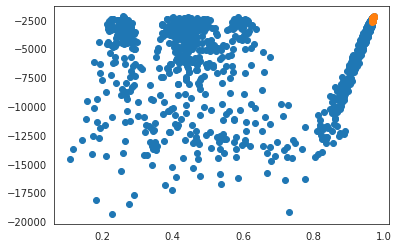

In [252]:
plt.scatter(score2, score1)
plt.scatter(score2[best_runs], score1[best_runs])

In [253]:
pi_avg = []
for comm_idx in range(num_comm):
    selected_df = df_memship.loc[df_memship.OC_idx == comm_idx]
    selected_df = selected_df.groupby('node').mean()
    
    pi_avg.append(selected_df.pi.values.reshape(1, -1))
pi_avg = np.concatenate(pi_avg)
pi_avg.shape

(4, 256)

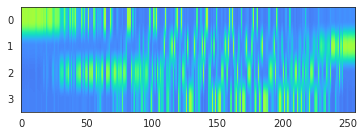

In [254]:
plt.imshow(pi_avg, aspect=20, vmin=0, vmax=1, cmap='turbo')

In [255]:
selected_df

,OC_idx,run_idx,pi
node,,,
0,3.0,454.5,0.162748
1,3.0,454.5,0.162552
2,3.0,454.5,0.162093
3,3.0,454.5,0.163819
4,3.0,454.5,0.162076
...,...,...,...
251,3.0,454.5,0.148421
252,3.0,454.5,0.149891
253,3.0,454.5,0.157955


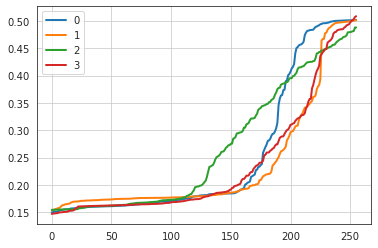

In [257]:
for comm_idx in range(num_comm):
    plt.plot(sorted(pi_avg[comm_idx]), label=comm_idx, lw=2)
plt.legend()
plt.grid()
plt.show()

In [258]:
pi_avg = []
for comm_idx in range(num_comm):
    selected_df = df_memship.loc[
        (df_memship.OC_idx == comm_idx) &
        (df_memship.run_idx.isin(best_runs))
    ]
    selected_df = selected_df.groupby('node').mean()
    
    pi_avg.append(selected_df.pi.values.reshape(1, -1))
pi_avg = np.concatenate(pi_avg)
pi_avg /= pi_avg.sum(0, keepdims=True)
pi_avg.shape

(4, 256)

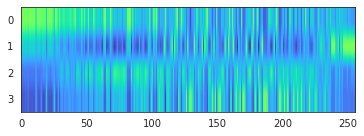

In [259]:
plt.imshow(pi_avg, aspect=20, vmin=0, vmax=1, cmap='turbo')

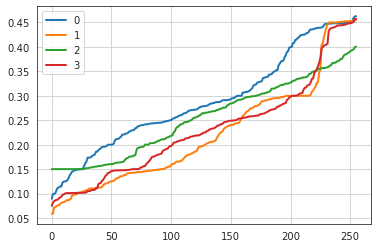

In [260]:
for comm_idx in range(num_comm):
    plt.plot(sorted(pi_avg[comm_idx]), label=comm_idx, lw=2)
plt.legend()
plt.grid()
plt.show()

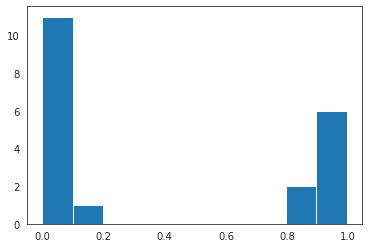

In [261]:
comm_idx = 2
node = 72
selected_df = df_memship.loc[
    (df_memship.OC_idx == comm_idx) &
    (df_memship.run_idx.isin(best_runs)) &
    (df_memship.node == node)
]
selected_df = reset_df(selected_df)

_ = plt.hist(selected_df.pi.values)
plt.show()

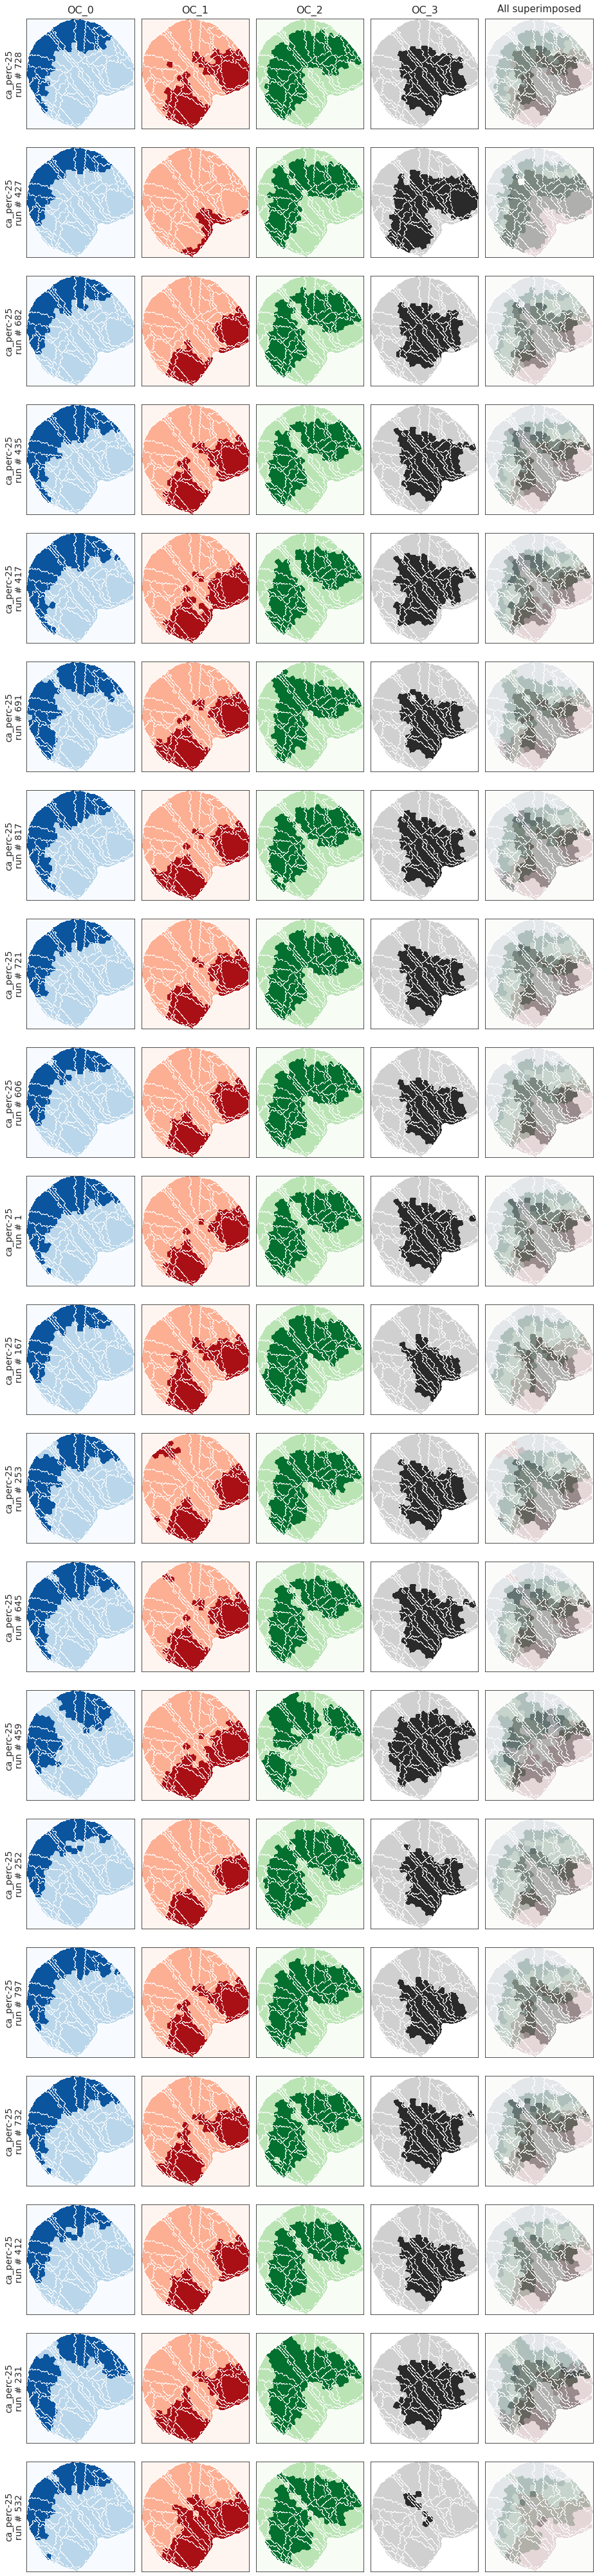

In [262]:
name = 'ca_perc-25'
selected_runs = best_runs

sns.set_style('white')
nrows, ncols = len(selected_runs), num_comm + 1
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 2.8 * nrows))
axes = axes.reshape((nrows, ncols))

for comm_idx in range(num_comm):
    for i, run_idx in enumerate(selected_runs):
        cmap = cmaps[comm_idx]
        comm_list = svinet_ordered[name][run_idx]['community'][comm_idx]
        
        x = np.ones(load['atlas_kmeans'].shape) * -1
        y = np.ones(load['atlas_kmeans'].shape) * -1
        x[load['mask']] = 0.
        for node in comm_list:
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = 2
            y[load['atlas_kmeans'] == region_id] = 2
        
        # x[load['atlas_kmeans'] == 72] = 3
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        axes[i, comm_idx].imshow(data2plt, cmap=cmap, interpolation='none', vmin=-1, vmax=2.5)
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])

        data2plt = np.ma.masked_where(atls_org['contour'], y)
        axes[i, -1].imshow(data2plt, cmap=cmap, interpolation='none', alpha=0.3)
        axes[i, -1].set_xticks([])
        axes[i, -1].set_yticks([])
        
        if i == 0:
            axes[i, comm_idx].set_title('OC_{:d}'.format(comm_idx), fontsize=16, y=1.02)
            axes[i, -1].set_title('All superimposed', fontsize=15, y=1.03)
            
        if comm_idx == 0:
            axes[i, comm_idx].set_ylabel('{:s}\nrun # {:d}'.format(name, run_idx), fontsize=14)

fig.tight_layout()
plt.show()

In [263]:
pi = {}

for run_idx in best_runs:
    _pi = []
    for comm_idx in range(num_comm):
        selected_df = df_memship.loc[
            (df_memship.OC_idx == comm_idx) &
            (df_memship.run_idx == run_idx)
        ]
        _pi.append(selected_df.pi.values.reshape(1, -1))
    _pi = np.concatenate(_pi)
    _pi /= _pi.sum(0, keepdims=True)
    
    pi[run_idx] = _pi

In [264]:
pi.keys()

dict_keys([728, 427, 682, 435, 417, 691, 817, 721, 606, 1, 167, 253, 645, 459, 252, 797, 732, 412, 231, 532])

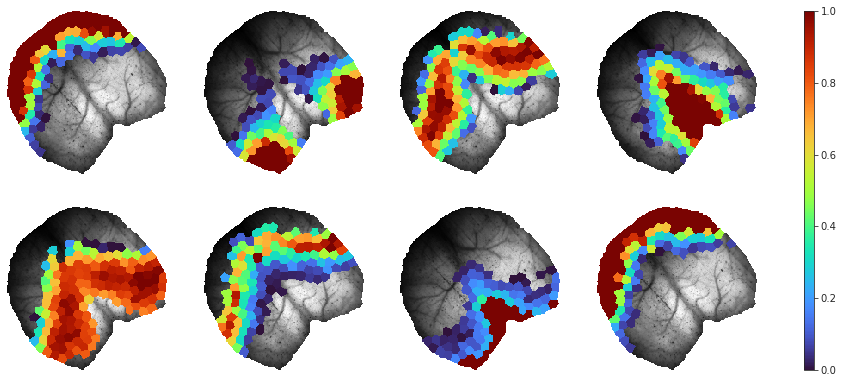

In [277]:
sns.set_style('white')
selected_runs = best_runs[:2]

nrows, ncols = len(selected_runs), num_comm
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 3.3*nrows))
axes = axes.reshape(nrows, ncols)

for comm_idx in range(num_comm):
    for i, run_idx in enumerate(selected_runs):
        x = load['ref']
        cond = functools.reduce(np.logical_or, [~load['mask']])
        data2plt = np.ma.masked_where(cond, x)
        axes[i, comm_idx].imshow(data2plt, cmap='Greys_r', interpolation='none', alpha=1.0)
        
        x = np.zeros(load['atlas_kmeans'].shape)
        for node in range(pi_avg.shape[1]):
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = pi[run_idx][comm_idx, node]
        
        cond = functools.reduce(np.logical_or, [~load['mask'], x == 0])
        data2plt = np.ma.masked_where(cond, x)
        im = axes[i, comm_idx].imshow(data2plt, cmap='turbo', interpolation='none')
        # plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)
        
        list(map(lambda x: x.set_visible(False), axes[i, comm_idx].spines.values()))
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])
        
        # if i == 0:
         #   axes[i, j].set_title('{:s}'.format(lbl), fontsize=14, y=1.1)
            
        # if j == 0:
        #     axes[0, j].set_ylabel('real graph\n', fontsize=13)
         #    axes[1, j].set_ylabel('configuration model\n', fontsize=13)

# msg = 'Node centralities,   top row: real graph,   bottom row: configuration model'
# fig.suptitle(msg, fontsize=15, y=0.98)
# fig.tight_layout()

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.3 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='turbo'), cax=cax, orientation="vertical")
fig.savefig('memships_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

### TODO: write function that converts community list ---> community_cortex (4 viz)


### Old stuff below

In [114]:
num_comm = 4
mapping = {i: i for i in range(num_comm)}

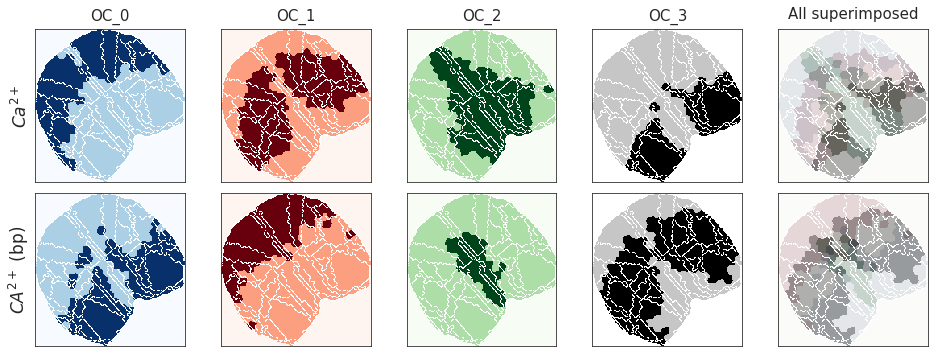

In [115]:
sns.set_style('white')
fig, axes = plt.subplots(2, num_comm + 1, figsize=(13.5, 5))

svinet = svinet_results['ca_perc-25'][554]
svinet_bp = svinet_results['ca_bp_perc-25'][168]

for comm_idx in range(num_comm):
    for i in range(2):
        cmap = cmaps[comm_idx]
        comm_list = svinet['community'][comm_idx] if i == 0 else svinet_bp['community'][mapping[comm_idx]]
        
        x = np.ones(load['atlas_kmeans'].shape) * -1
        y = np.ones(load['atlas_kmeans'].shape) * -1
        x[load['mask']] = 0.
        for node in comm_list:
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = 2
            y[load['atlas_kmeans'] == region_id] = 2
        
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        axes[i, comm_idx].imshow(data2plt, cmap=cmap, interpolation='none')
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])

        data2plt = np.ma.masked_where(atls_org['contour'], y)
        axes[i, -1].imshow(data2plt, cmap=cmap, interpolation='none', alpha=0.3)
        axes[i, -1].set_xticks([])
        axes[i, -1].set_yticks([])
        
        if i == 0:
            axes[i, comm_idx].set_title('OC_{:d}'.format(comm_idx), fontsize=15, y=1.02)
            axes[i, -1].set_title('All superimposed', fontsize=15, y=1.03)
            
        if comm_idx == 0:
            axes[0, comm_idx].set_ylabel('$Ca^{2+}$', fontsize=17)
            axes[1, comm_idx].set_ylabel('$CA^{2+}$ (bp)', fontsize=17)

fig.tight_layout()
plt.show()

In [116]:
mapping = {
    0: 1,
    1: 3,
    2: 2,
    3: 0,
    # 4: 3,
}

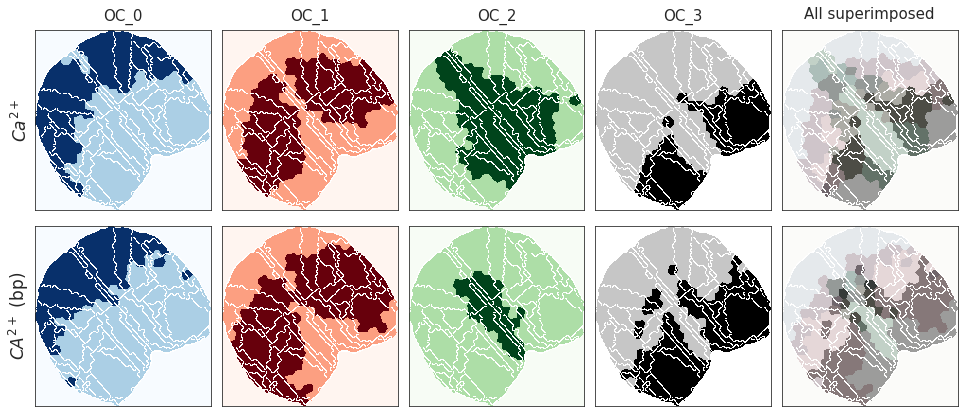

In [117]:
sns.set_style('white')
fig, axes = plt.subplots(2, num_comm + 1, figsize=(13.5, 6))

for comm_idx in range(num_comm):
    for i in range(2):
        cmap = cmaps[comm_idx]
        comm_list = svinet['community'][comm_idx] if i == 0 else svinet_bp['community'][mapping[comm_idx]]
        
        x = np.ones(load['atlas_kmeans'].shape) * -1
        y = np.ones(load['atlas_kmeans'].shape) * -1
        x[load['mask']] = 0.
        for node in comm_list:
            region_id = node_labels[node]
            x[load['atlas_kmeans'] == region_id] = 2
            y[load['atlas_kmeans'] == region_id] = 2
        
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        axes[i, comm_idx].imshow(data2plt, cmap=cmap, interpolation='none')
        axes[i, comm_idx].set_xticks([])
        axes[i, comm_idx].set_yticks([])

        data2plt = np.ma.masked_where(atls_org['contour'], y)
        axes[i, -1].imshow(data2plt, cmap=cmap, interpolation='none', alpha=1.5/num_comm)
        axes[i, -1].set_xticks([])
        axes[i, -1].set_yticks([])
        
        if i == 0:
            axes[i, comm_idx].set_title('OC_{:d}'.format(comm_idx), fontsize=15, y=1.02)
            axes[i, -1].set_title('All superimposed', fontsize=15, y=1.03)
            
        if comm_idx == 0:
            axes[0, comm_idx].set_ylabel('$Ca^{2+}$', fontsize=17)
            axes[1, comm_idx].set_ylabel('$CA^{2+}$ (bp)', fontsize=17)

fig.tight_layout()
# fig.savefig('comms_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

In [94]:
# pred membership probabilities
pi = np.concatenate([np.reshape(x, (1, -1)) for x in svinet['membership'].values()]).T
pi_bp = np.concatenate([np.reshape(x, (1, -1)) for x in svinet_bp['membership'].values()]).T

# pi_cfg = np.concatenate([np.reshape(x, (1, -1)) for x in svinet_cfg['membership'].values()]).T
# pi_cfg_bp = np.concatenate([np.reshape(x, (1, -1)) for x in svinet_cfg_bp['membership'].values()]).T

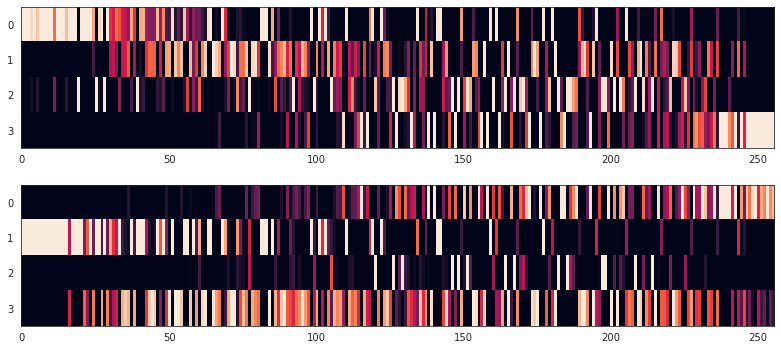

In [97]:
plt.figure(figsize=(13.5, 6))

plt.subplot(211)
plt.imshow(pi, aspect=12, interpolation='none')

plt.subplot(212)
plt.imshow(pi_bp, aspect=12, interpolation='none')

In [98]:
from sklearn.metrics.pairwise import cosine_similarity

In [100]:
cos_sim = cosine_similarity(pi, pi_bp)
print(np.round(cos_sim, decimals=1), '\n')

thres = 0.2
similarity = dict()
for true_idx in range(num_comm):
    sim_vec = np.where(cos_sim[true_idx] >= thres)[0]
    sim_vec = [x for _, x in sorted(zip(cos_sim[true_idx][sim_vec], sim_vec), reverse=True)]
    similarity[true_idx] = list(sim_vec)
print(similarity)

[[0.  0.9 0.  0.3]
 [0.2 0.1 0.  0.9]
 [0.4 0.2 0.8 0.2]
 [0.9 0.  0.  0.2]] 

{0: [1, 3], 1: [3], 2: [2, 0], 3: [0, 3]}


In [101]:
mapping

{0: 1, 1: 3, 2: 2, 3: 0}

In [104]:
# mapping = {i: sim[0] for i, sim in similarity.items()}
# mapping = {0: 2, 1: 3, 2: 0, 3: 4, 4: 1}
# pi_pred_bp = pi_pred_bp[list(mapping.values())]



In [102]:
cos_sim = cosine_similarity(pi, pi_bp[list(mapping.values())])

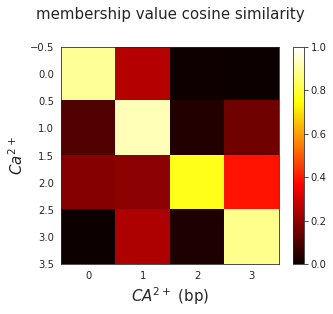

In [106]:
plt.figure(figsize=(5, 4))
plt.imshow(cos_sim, vmin=0, vmax=1, cmap='hot', interpolation='none')
plt.ylabel('$Ca^{2+}$', fontsize=15)
plt.xlabel('$CA^{2+}$ (bp)', fontsize=15)
plt.title('membership value cosine similarity', fontsize=15, y=1.1)
plt.colorbar()
# plt.savefig('memship_cossim_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

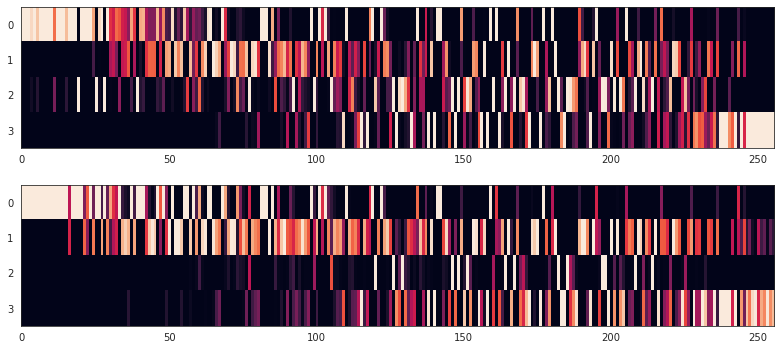

In [108]:
plt.figure(figsize=(13.5, 6))

plt.subplot(211)
plt.imshow(pi, aspect=12, interpolation='none')

plt.subplot(212)
plt.imshow(pi_bp[list(mapping.values())], aspect=12, interpolation='none')

plt.show()

In [109]:
n_nodes = g.order()
dict_list = []
for i in range(num_comm):
    data_dict = {
        'network_name': ['ca'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi[i],
    }
    dict_list.append(data_dict)
    
    data_dict = {
        'network_name': ['ca_bp'] * n_nodes,
        'cluster': [i] * n_nodes,
        'node': range(n_nodes),
        'p': pi_bp[mapping[i]],
    }
    dict_list.append(data_dict)
df = pd.DataFrame.from_dict(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

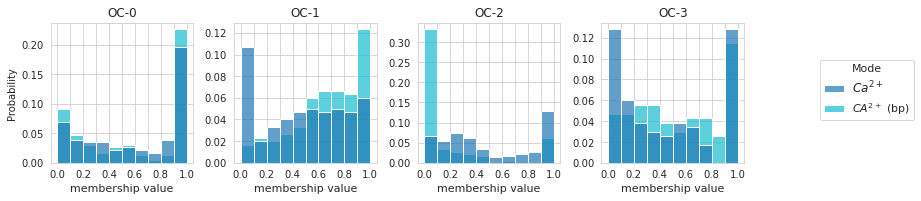

In [110]:
sns.set_style('whitegrid')
ncols = num_comm
nrows = int(np.ceil(num_comm / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(13, 2.9))#, sharex='all')
axes = axes.reshape(nrows, ncols)

bins = np.linspace(0, 1, 11)
ticklabels = [np.round(item, decimals=1) if idx%2 == 0 else '' for idx, item in enumerate(bins)]
for idx in range(nrows*ncols):
    i, j = idx//ncols, idx%ncols
    union = set(svinet['community'][idx]).union(set(svinet_bp['community'][mapping[idx]]))
    selected_df = df.loc[(df.cluster == idx) & (df.node.isin(union))]
    hist = sns.histplot(
        data=selected_df,
        x='p',
        hue='network_name',
        stat='probability',
        # kde=True,
        alpha=0.7,
        bins=bins,
        # legend=True if idx == 2 else False,
        legend=True if idx == num_comm - 1 else False,
        palette=['C0', 'C9'],
        # line_kws={'lw': 2, 'alpha': 0.8},
        ax=axes[i, j],
    )
    leg = hist.get_legend()
    if leg is not None:
        plt.setp(leg.get_texts()[0], text='$Ca^{2+}$', fontsize=12)
        plt.setp(leg.get_texts()[1], text='$CA^{2+}$ (bp)', fontsize=11)
        plt.setp(leg.get_title(), text='Mode', fontsize=11)
        plt.setp(leg, bbox_to_anchor=(1.5, 0.77))
    axes[i, j].set_title('OC-{:d}'.format(idx), fontsize=12)
    axes[i, j].set_xticks(bins)
    axes[i, j].set_xticklabels(ticklabels)
    axes[i, j].set_xlabel('membership value', fontsize=11)
    
    if j > 0:
        axes[i, j].set_ylabel('')

fig.tight_layout()
fig.savefig('memship_hist_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

### Visualize memship values on cortex

In [111]:
run = 1
regions = {}
tot_num_regions = {}
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        if _load is None:
            continue
        _atlsorg = organize_atlas(_load)
        key = 'sub-SLC{:02d}_ses-{:d}'.format(subject, session)
        regions[key] = _atlsorg['regions']
        tot_num_regions[key] = len(_atlsorg['regions'])

common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
common_regions = {k: config.region_labels[k] for k in sorted(common_regions)}
common_r = [item[2:] for item in common_regions.values() if item[:2] == 'R-']
common_l = [item[2:] for item in common_regions.values() if item[:2] == 'L-']
common_global = set(common_r).intersection(common_l)
common_regions = {k: v for k, v in common_regions.items() if v[2:] in common_global}
len(common_regions)

44

## Node centralities

In [114]:
from scipy import special as sp_special

ent = sp_special.entr(pi).sum(0) / np.log(num_comm)
ent_bp = sp_special.entr(pi_bp).sum(0) / np.log(num_comm)

ent_cfg = sp_special.entr(pi_cfg).sum(0) / np.log(num_comm)
ent_bp_cfg = sp_special.entr(pi_cfg_bp).sum(0) / np.log(num_comm)

In [116]:
selected_graphs = {'ca': g, 'bold': g_bp}
selected_graphs_cfg = {'ca': g_cfg, 'bold': g_bp_cfg}

In [117]:
centralities = {}
centralities_cfg = {}

for key in ['ca', 'bold']:
    # real
    _graph = selected_graphs[key]
    degree = nx.degree_centrality(_graph)
    closeness = nx.closeness_centrality(_graph, distance='weight')
    betweenness = nx.betweenness_centrality(_graph, weight='weight')
    eigenvector = nx.eigenvector_centrality(_graph, weight='weight')

    centralities[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'entropy': {i: ent[i]/max(ent) for i in range(g.order())},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
    }
    for comm_idx in range(num_comm):
        memship_vec = pi_pred[comm_idx] if key == 'ca' else pi_pred_bp[mapping[comm_idx]]
        memship_dict = {node: memship_vec[node]/max(memship_vec) for node in _graph.nodes}
        centralities[key].update({'OC_{:d}_memship'.format(comm_idx): memship_dict})

    # cfg
    _cfg = selected_graphs_cfg[key]
    degree = nx.degree_centrality(_cfg)
    closeness = nx.closeness_centrality(_cfg, distance='weight')
    betweenness = nx.betweenness_centrality(_cfg, weight='weight')
    eigenvector = nx.eigenvector_centrality(_cfg, weight='weight')

    centralities_cfg[key] = {
        'degree': {k: v/max(list(degree.values())) for k, v in degree.items()},
        'entropy': {i: ent_cfg[i]/max(ent_cfg) for i in range(g.order())},
        'closeness': {k: v/max(list(closeness.values())) for k, v in closeness.items()},
        'betweenness': {k: v/max(list(betweenness.values())) for k, v in betweenness.items()},
        # 'eigenvector': {k: v/max(list(eigenvector.values())) for k, v in eigenvector.items()},
    }
    for comm_idx in range(num_comm):
        memship_vec = pi_pred_cfg[comm_idx] if key == 'ca' else pi_pred_bp_cfg[mapping[comm_idx]]
        memship_dict = {node: memship_vec[node]/max(memship_vec) for node in _cfg.nodes}
        centralities_cfg[key].update({'OC_{:d}_memship'.format(comm_idx): memship_dict})

In [118]:
key = 'ca'

centralities_cortex = {}
for lbl, centrality_d in centralities[key].items():
    x = np.ones(load['atlas_kmeans'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas_kmeans'] == region_id] = value
    centralities_cortex[lbl] = x

centralities_cortex_cfg = {}
for lbl, centrality_d in centralities_cfg[key].items():
    x = np.ones(load['atlas_kmeans'].shape, dtype=float) * np.nan
    for node, value in centrality_d.items():
        region_id = node_labels[node]
        x[load['atlas_kmeans'] == region_id] = value
    centralities_cortex_cfg[lbl] = x

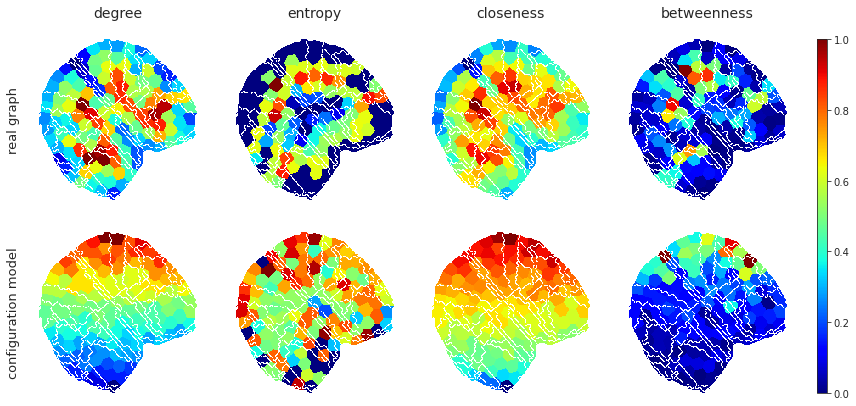

In [130]:
sns.set_style('white')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 6.5))
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(centralities_cortex.keys()):
    if 'memship' in lbl:
        continue
    for i in range(2):
        x = centralities_cortex[lbl] if i == 0 else centralities_cortex_cfg[lbl]
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')

        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if i == 0:
            axes[i, j].set_title('{:s}'.format(lbl), fontsize=14, y=1.1)
            
        if j == 0:
            axes[0, j].set_ylabel('real graph\n', fontsize=13)
            axes[1, j].set_ylabel('configuration model\n', fontsize=13)

# msg = 'Node centralities,   top row: real graph,   bottom row: configuration model'
#fig.suptitle(msg, fontsize=15, y=0.98)

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.2 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
fig.savefig('centralities_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

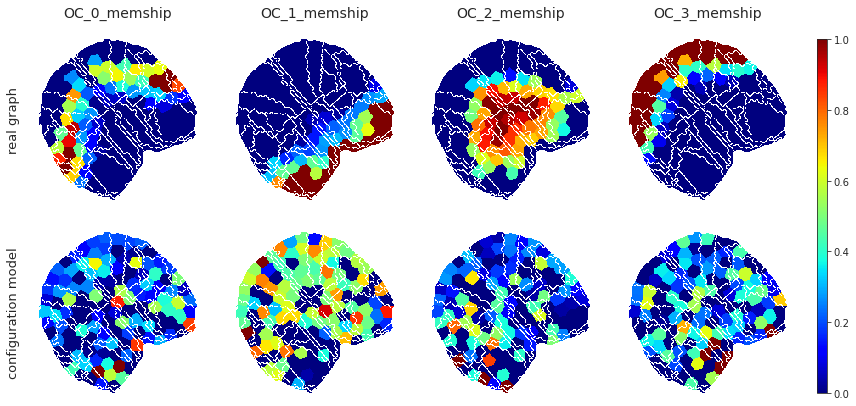

In [131]:
sns.set_style('white')
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 6.5))
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(centralities_cortex.keys()):
    if 'memship' not in lbl:
        continue
    j -= 4
    for i in range(2):
        x = centralities_cortex[lbl].copy() if i == 0 else centralities_cortex_cfg[lbl].copy()
        x[x < 0.01] = 0
        data2plt = np.ma.masked_where(atls_org['contour'], x)
        im = axes[i, j].imshow(data2plt, cmap='jet', interpolation='none')
        # plt.colorbar(mappable=im, ax=axes[i, j], aspect=40, shrink=0.5)
        
        list(map(lambda x: x.set_visible(False), axes[i, j].spines.values()))
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        
        if i == 0:
            axes[i, j].set_title('{:s}'.format(lbl), fontsize=14, y=1.1)
            
        if j == 0:
            axes[0, j].set_ylabel('real graph\n', fontsize=13)
            axes[1, j].set_ylabel('configuration model\n', fontsize=13)

# msg = 'Node centralities,   top row: real graph,   bottom row: configuration model'
# fig.suptitle(msg, fontsize=15, y=0.98)
# fig.tight_layout()

pos0 = axes[0, -1].get_position()
pos1 = axes[-1, -1].get_position()
rect = [
    pos1.x0 + 1.2 * pos1.width, # left
    pos1.y0, # bottom
    pos1.width / 17, # width
    pos0.y0 - pos1.y0 + pos1.height, # height
]
cax = fig.add_axes(rect)
fig.colorbar(cm.ScalarMappable(cmap='jet'), cax=cax, orientation="vertical")
fig.savefig('memships_cortex_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()

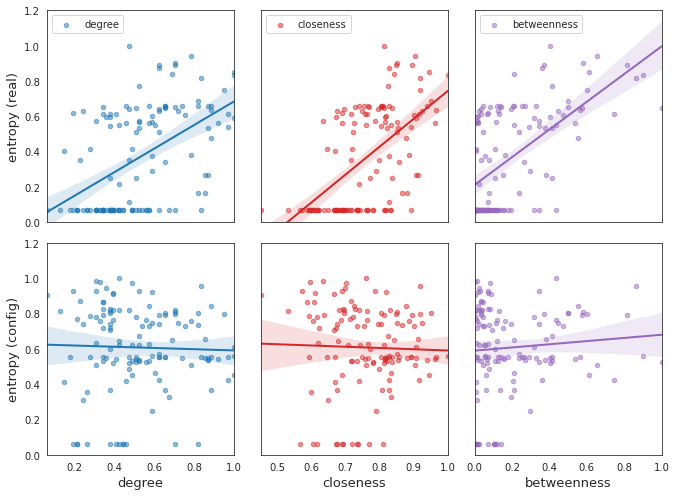

In [129]:
key = 'ca'
_lbls = {
    'degree': 'C0',
    'closeness': 'C3',
    'betweenness': 'C4',
    # 'eigenvector': 'C5',
}

sns.set_style('white')
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(9.5, 7), sharey='row', sharex='col')
axes = axes.reshape(nrows, ncols)

for j, lbl in enumerate(_lbls):
    x = list(centralities[key][lbl].values())
    for i in range(2):
        if i == 0:
            y = list(centralities[key]['entropy'].values())
        else:
            y = list(centralities_cfg[key]['entropy'].values())
        sns.regplot(
            x=x,
            y=y,
            color=_lbls[lbl],
            label=lbl,
            x_ci='sd',
            line_kws={'lw': 2},
            scatter_kws={'alpha': 0.5, 's': 20,},
            ax=axes[i, j],
        )
        axes[i, j].set_ylim(0, 1.2)
        if i == 0:
            axes[i, j].legend(loc='upper left')
        else:
            axes[i, j].set_xlabel(lbl, fontsize=13)
            
        
    if j == 0:
        axes[0, j].set_ylabel('entropy (real)', fontsize=13)
        axes[1, j].set_ylabel('entropy (config)', fontsize=13)

fig.tight_layout()
fig.savefig('centralities_regscatter_perc{:d}_OC{:d}.pdf'.format(perc, num_comm), dpi=300, bbox_inches='tight')
plt.show()